In [1]:
import pickle
import numpy as np 

from sklearn.model_selection import train_test_split

import keras
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50


import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

# from tqdm import tqdm_notebook, tnrange

import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt 


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7074777163242194340
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13988265916239062030
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9684141339044209816
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10585558221
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16660980158945540368
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [2]:
x_train = np.load('x_train.npy')
x_cv = np.load('x_cv.npy')

y_train = np.load('y_train.npy')
y_cv = np.load('y_cv.npy')

X_train_flattened = [] 

for i in range(len(x_train)):
    X_train_flattened.append(x_train[i].flatten())
    
X_cv_flattened = []

for i in range(len(x_cv)):
    X_cv_flattened.append(x_cv[i].flatten() )
    
X_cv_flattened = np.array(X_cv_flattened).astype('float32') / 255.
X_train_flattened = np.array(X_train_flattened).astype('float32') / 255.
    
X_train_flattened.shape, X_cv_flattened.shape

((74708, 12288), (18677, 12288))

In [3]:
class MyDataset(Dataset):
  def __init__(self, X, transform):
    self.X = X 
    self.transform = transform 
    
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    
    if self.transform:
      self.X[idx] = self.transform(self.X[idx])
      
    return self.X[idx], self.X[idx]

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # nn.Linear(#input_nodes, #output_nodes)
            nn.Linear(64*64*3, 5000),
            nn.ReLU(True),
            nn.Linear(5000, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 300),
            nn.ReLU(True),
            nn.Linear(300, 100),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.Linear(100, 300),
            nn.ReLU(True),
            nn.Linear(300, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 5000),
            nn.ReLU(True), 
            nn.Linear(5000, 64*64*3),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
my_X_train = MyDataset(X_train_flattened, None)

data_loader = torch.utils.data.DataLoader(dataset=my_X_train, batch_size = 256, shuffle = True)

In [6]:
def to_img(x):
    x = x.view(x.size(0), 3, 64, 64)
    return x


In [10]:
num_epochs = 100
learning_rate = 1e-3


model = autoencoder().cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)


for epoch in range(num_epochs):
  for i, (img, _) in enumerate(data_loader):
    
    # test = img[0].reshape((64, 64, 3))

    img = img.cuda()
    output = model(img)
    loss = criterion(output, img)
    MSE_loss = nn.MSELoss()(output, img)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  print('epoch [{}/{}], loss:{:.4f}, MSE_loss:{:.4f}'
        .format(epoch + 1, num_epochs, loss.data, MSE_loss.data))
    
  if epoch % 5 == 0:
      x = to_img(img.cpu().data)
      x_hat = to_img(output.cpu().data)
      save_image(x, 'img/x_{}.png'.format(epoch))
      save_image(x_hat, 'img/x_hat_{}.png'.format(epoch))


epoch [1/100], loss:0.6037, MSE_loss:0.0207
epoch [2/100], loss:0.6131, MSE_loss:0.0262
epoch [3/100], loss:0.5977, MSE_loss:0.0229
epoch [4/100], loss:0.5832, MSE_loss:0.0202
epoch [5/100], loss:0.5777, MSE_loss:0.0146
epoch [6/100], loss:0.5731, MSE_loss:0.0138
epoch [7/100], loss:0.5725, MSE_loss:0.0125
epoch [8/100], loss:0.5559, MSE_loss:0.0120
epoch [9/100], loss:0.5607, MSE_loss:0.0134
epoch [10/100], loss:0.5726, MSE_loss:0.0127
epoch [11/100], loss:0.5588, MSE_loss:0.0140
epoch [12/100], loss:0.5620, MSE_loss:0.0113
epoch [13/100], loss:0.5771, MSE_loss:0.0142
epoch [14/100], loss:0.5755, MSE_loss:0.0107
epoch [15/100], loss:0.5639, MSE_loss:0.0125
epoch [16/100], loss:0.5447, MSE_loss:0.0133
epoch [17/100], loss:0.5712, MSE_loss:0.0115
epoch [18/100], loss:0.5697, MSE_loss:0.0113
epoch [19/100], loss:0.5649, MSE_loss:0.0110
epoch [20/100], loss:0.5797, MSE_loss:0.0121
epoch [21/100], loss:0.5668, MSE_loss:0.0127
epoch [22/100], loss:0.5652, MSE_loss:0.0116
epoch [23/100], los

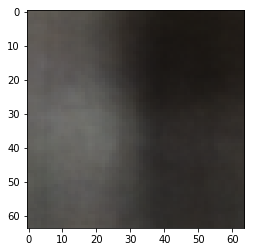

In [13]:
for i, (img, _) in enumerate(data_loader):

  test = img[145].reshape((64, 64, 3))
  break
    
output = model(test.reshape((1, 64*64*3)).cuda())
plt.imshow(output.cpu().detach().numpy().reshape((64, 64, 3)))

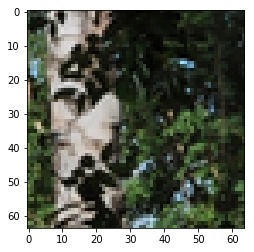

In [14]:
plt.imshow(test)